In [1]:
import numpy as np
import os
#from scipy.misc.pilutil import imread, imresize
import imageio.v2 as imageio
from imageio import imread
import datetime
from skimage.transform import resize

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [3]:
train_doc = np.random.permutation(open('C:\\Users\\JITHAN\\Downloads\\Project_data\\train.csv').readlines())
val_doc = np.random.permutation(open('C:\\Users\\JITHAN\\Downloads\\Project_data\\val.csv').readlines())
batch_size = 16

In [4]:
train_path="C:\\Users\\JITHAN\\Downloads\\Project_data\\train"
val_path="C:\\Users\\JITHAN\\Downloads\\Project_data\\val"

In [5]:
resize_val = 128

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = [0,3,7,8,10] #create a list of image numbers you want to use for a particular video
    img_idx = list(range(0,30))
    
    ## Complete Batches
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,30,resize_val,resize_val,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized=resize(image,(resize_val,resize_val,3))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        last_batch_size = len(t)%batch_size
        if last_batch_size:
            batch_data = np.zeros((batch_size,30,resize_val,resize_val,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(last_batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized=resize(image,(resize_val,resize_val,3))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



In [7]:
train_gen = generator(train_path,train_doc,30)

In [8]:
curr_dt_time = datetime.datetime.now()
train_path="C:\\Users\\JITHAN\\Downloads\\Project_data\\train"
val_path="C:\\Users\\JITHAN\\Downloads\\Project_data\\val"
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [10]:
cnn_model = Sequential()
cnn_model.add(Conv3D(16, (3, 3, 3), padding='same',
         input_shape=(30,resize_val,resize_val,3)))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling3D(pool_size=(2, 2, 2)))

cnn_model.add(Conv3D(32, (2, 2, 2), padding='same'))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling3D(pool_size=(2, 2, 2)))

cnn_model.add(Conv3D(64, (2, 2, 2), padding='same'))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling3D(pool_size=(2, 2, 2)))

cnn_model.add(Conv3D(128, (2, 2, 2), padding='same'))
cnn_model.add(Activation('relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling3D(pool_size=(2, 2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(64,activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.25))


cnn_model.add(Dense(5,activation='softmax'))

#optimiser = optimizers.Adam()
#optimiser = 'sgd'
cnn_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [11]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 128, 128, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 128, 128, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 128, 128, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 64, 64, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 64, 64, 32)    0

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=5)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [15]:
num_epochs=50
cnn_model_history= cnn_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                 callbacks=callbacks_list, validation_data=val_generator, 
                                 validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:\Users\JITHAN\Downloads\Project_data\train ; batch size = 16


C:\Users\JITHAN\AppData\Local\Temp/ipykernel_57288/2932977404.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/50
40/42 [===========================>..] - ETA: 21s - loss: 1.6939 - categorical_accuracy: 0.3609

C:\Users\JITHAN\AppData\Local\Temp/ipykernel_57288/2932977404.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


42/42 [==============================] - 502s 12s/step - loss: 1.6723 - categorical_accuracy: 0.3571 - val_loss: 39.1884 - val_categorical_accuracy: 0.2679 - lr: 0.0100
Epoch 2/50
42/42 [==============================] - 478s 11s/step - loss: 1.5370 - categorical_accuracy: 0.4122 - val_loss: 84.4824 - val_categorical_accuracy: 0.1964 - lr: 0.0100
Epoch 3/50
42/42 [==============================] - 473s 11s/step - loss: 1.2874 - categorical_accuracy: 0.4836 - val_loss: 16.9487 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 4/50
42/42 [==============================] - 474s 11s/step - loss: 1.1640 - categorical_accuracy: 0.5327 - val_loss: 37.5335 - val_categorical_accuracy: 0.2232 - lr: 0.0100
Epoch 5/50
42/42 [==============================] - ETA: 0s - loss: 1.0637 - categorical_accuracy: 0.5714 
Epoch 5: val_loss improved from inf to 8.30673, saving model to model_init_2022-07-1208_12_49.860346\model-00005-1.06375-0.57143-8.30673-0.25000.h5
42/42 [=============================

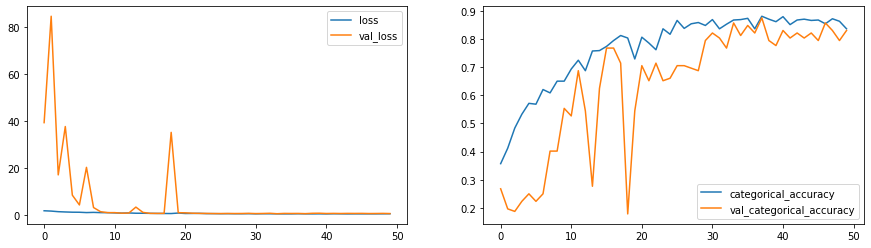

In [16]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(cnn_model_history.history['loss'])   
axes[0].plot(cnn_model_history.history['val_loss'])
axes[0].legend(['loss','val_loss'])

axes[1].plot(cnn_model_history.history['categorical_accuracy'])   
axes[1].plot(cnn_model_history.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [17]:
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [18]:
gru_model = Sequential()

gru_model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(30,resize_val,resize_val,3)))
gru_model.add(TimeDistributed(BatchNormalization()))
gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))

gru_model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
gru_model.add(TimeDistributed(BatchNormalization()))
gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))

gru_model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
gru_model.add(TimeDistributed(BatchNormalization()))
gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))

gru_model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
gru_model.add(TimeDistributed(BatchNormalization()))
gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))


gru_model.add(TimeDistributed(Flatten()))


gru_model.add(GRU(128))
gru_model.add(Dropout(0.5))

gru_model.add(Dense(64,activation='relu'))
gru_model.add(Dropout(0.25))

gru_model.add(Dense(5, activation='softmax'))
gru_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [19]:
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 128, 128, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 128, 128, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 64, 64, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 64, 64, 32)  

In [20]:
num_epochs=50
gru_model_history = gru_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator, 
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\JITHAN\AppData\Local\Temp/ipykernel_57288/2932977404.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/50
39/42 [==========================>...] - ETA: 19s - loss: 1.6316 - categorical_accuracy: 0.3478

C:\Users\JITHAN\AppData\Local\Temp/ipykernel_57288/2932977404.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


42/42 [==============================] - 299s 7s/step - loss: 1.5961 - categorical_accuracy: 0.3497 - val_loss: 1.3850 - val_categorical_accuracy: 0.3482 - lr: 0.0100
Epoch 2/50
42/42 [==============================] - 302s 7s/step - loss: 1.2906 - categorical_accuracy: 0.4598 - val_loss: 1.6391 - val_categorical_accuracy: 0.2857 - lr: 0.0100
Epoch 3/50
42/42 [==============================] - 300s 7s/step - loss: 0.9972 - categorical_accuracy: 0.6027 - val_loss: 1.4679 - val_categorical_accuracy: 0.3571 - lr: 0.0100
Epoch 4/50
42/42 [==============================] - 298s 7s/step - loss: 0.8863 - categorical_accuracy: 0.6354 - val_loss: 2.0028 - val_categorical_accuracy: 0.2768 - lr: 0.0100
Epoch 5/50
42/42 [==============================] - ETA: 0s - loss: 0.7410 - categorical_accuracy: 0.6935
Epoch 5: val_loss did not improve from 0.48438

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
42/42 [==============================] - 299s 7s/step - loss: 0.7410 

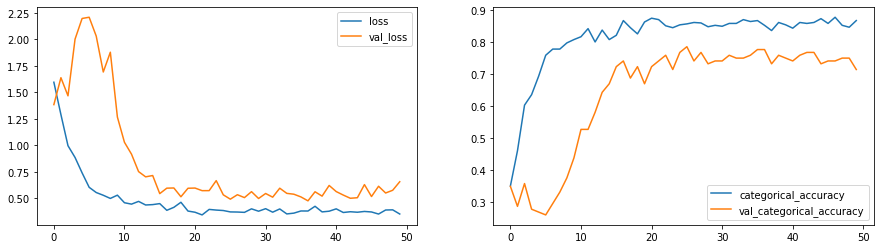

In [21]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(gru_model_history.history['loss'])   
axes[0].plot(gru_model_history.history['val_loss'])
axes[0].legend(['loss','val_loss'])

axes[1].plot(gru_model_history.history['categorical_accuracy'])   
axes[1].plot(gru_model_history.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [22]:
lstm_model = Sequential()

lstm_model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(30,resize_val,resize_val,3)))
lstm_model.add(TimeDistributed(BatchNormalization()))
lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

lstm_model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
lstm_model.add(TimeDistributed(BatchNormalization()))
lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

lstm_model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
lstm_model.add(TimeDistributed(BatchNormalization()))
lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))

lstm_model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
lstm_model.add(TimeDistributed(BatchNormalization()))
lstm_model.add(TimeDistributed(MaxPooling2D((2, 2))))


lstm_model.add(TimeDistributed(Flatten()))


lstm_model.add(LSTM(units=128))
lstm_model.add(Dropout(0.25))

lstm_model.add(Dense(64,activation='relu'))
lstm_model.add(Dropout(0.25))

lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [23]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 30, 128, 128, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 128, 128, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 64, 64, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 64, 64, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 64, 64, 32)  

In [24]:
num_epochs=50
lstm_model_history = lstm_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                                    callbacks=callbacks_list, validation_data=val_generator, 
                                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\JITHAN\AppData\Local\Temp/ipykernel_57288/2932977404.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/50
38/42 [==========================>...] - ETA: 26s - loss: 1.4820 - categorical_accuracy: 0.3273

C:\Users\JITHAN\AppData\Local\Temp/ipykernel_57288/2932977404.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


42/42 [==============================] - 302s 7s/step - loss: 1.4675 - categorical_accuracy: 0.3199 - val_loss: 1.4446 - val_categorical_accuracy: 0.2143 - lr: 0.0100
Epoch 2/50
42/42 [==============================] - 302s 7s/step - loss: 1.1365 - categorical_accuracy: 0.5298 - val_loss: 1.5426 - val_categorical_accuracy: 0.1339 - lr: 0.0100
Epoch 3/50
42/42 [==============================] - 301s 7s/step - loss: 0.9656 - categorical_accuracy: 0.6116 - val_loss: 1.4739 - val_categorical_accuracy: 0.2589 - lr: 0.0100
Epoch 4/50
42/42 [==============================] - 301s 7s/step - loss: 0.8314 - categorical_accuracy: 0.6815 - val_loss: 1.5453 - val_categorical_accuracy: 0.2143 - lr: 0.0100
Epoch 5/50
42/42 [==============================] - ETA: 0s - loss: 0.7358 - categorical_accuracy: 0.7143
Epoch 5: val_loss did not improve from 0.48438

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
42/42 [==============================] - 301s 7s/step - loss: 0.7358 

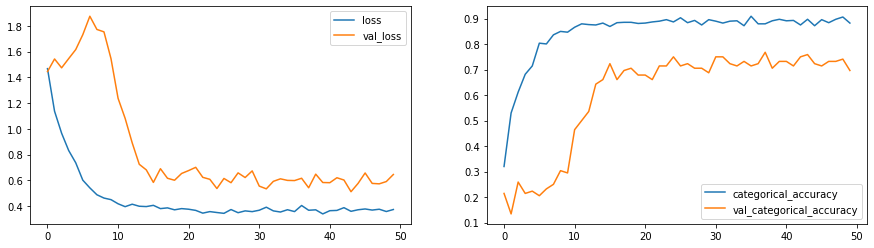

In [25]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(lstm_model_history.history['loss'])   
axes[0].plot(lstm_model_history.history['val_loss'])
axes[0].legend(['loss','val_loss'])

axes[1].plot(lstm_model_history.history['categorical_accuracy'])   
axes[1].plot(lstm_model_history.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [26]:
pip list

Package                      Version
---------------------------- -------------------
absl-py                      1.0.0
alice-blue                   1.0.2
anyio                        3.4.0
argon2-cffi                  21.1.0
asgiref                      3.4.1
astunparse                   1.6.3
attrs                        21.2.0
Augmentor                    0.2.10
Babel                        2.9.1
backcall                     0.2.0
beautifulsoup4               4.10.0
bleach                       4.1.0
bs4                          0.0.1
cachetools                   5.2.0
certifi                      2021.10.8
cffi                         1.15.0
charset-normalizer           2.0.8
click                        8.0.3
colorama                     0.4.4
cycler                       0.11.0
debugpy                      1.5.1
decorator                    5.1.0
defusedxml                   0.7.1
Django                       4.0.1
entrypoints                  0.3
et-xmlfile                   1.

You should consider upgrading via the 'C:\Python\python.exe -m pip install --upgrade pip' command.


imageio                      2.19.3
ipykernel                    6.5.1
ipython                      7.30.0
ipython-genutils             0.2.0
itsdangerous                 2.0.1
jedi                         0.18.1
Jinja2                       3.0.3
joblib                       1.1.0
json5                        0.9.6
jsonschema                   4.2.1
jupyter-client               7.1.0
jupyter-core                 4.9.1
jupyter-http-over-ws         0.0.8
jupyter-server               1.12.1
jupyterlab                   3.2.4
jupyterlab-pygments          0.1.2
jupyterlab-server            2.8.2
keras                        2.8.0
Keras-Preprocessing          1.1.2
kiwisolver                   1.3.2
libclang                     14.0.1
Markdown                     3.3.7
MarkupSafe                   2.0.1
matplotlib                   3.5.1
matplotlib-inline            0.1.3
mistune                      0.8.4
nbclassic                    0.3.4
nbclient                     0.5.9
nbconvert      